In [16]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [17]:
# Read the data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [18]:
# Combine datasets for preprocessing
test_data['Survived'] = None
combined = pd.concat([train_data, test_data], axis=0)

Train Data Shape: (891, 12)

Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Overall Survival Rate:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


/tmp/ipykernel_30/3576581593.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


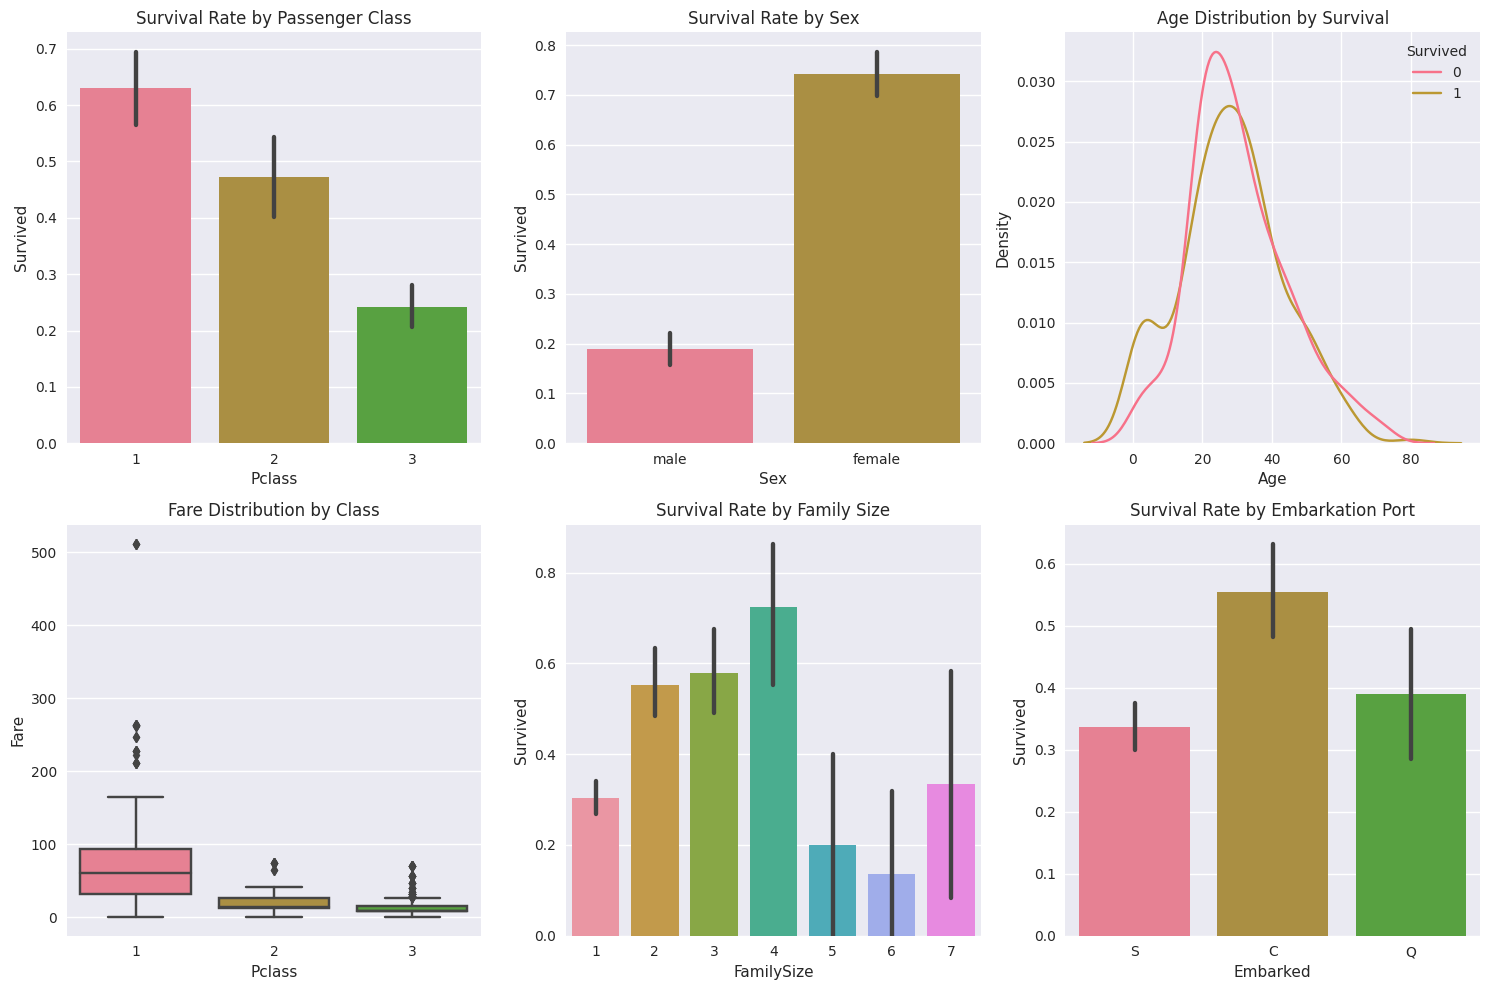

In [19]:
# Set up plotting style
plt.style.use('seaborn')
sns.set_palette("husl")

# Begin EDA
print("Train Data Shape:", train_data.shape)
print("\nMissing Values:")
print(train_data.isnull().sum())

# Survival rate overview
print("\nOverall Survival Rate:")
print(train_data['Survived'].value_counts(normalize=True))

# Create figure for survival demographics
plt.figure(figsize=(15, 10))

# Survival by Pclass
plt.subplot(2, 3, 1)
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.title('Survival Rate by Passenger Class')

# Survival by Sex
plt.subplot(2, 3, 2)
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.title('Survival Rate by Sex')

# Age distribution
plt.subplot(2, 3, 3)
sns.kdeplot(data=train_data, x='Age', hue='Survived', common_norm=False)
plt.title('Age Distribution by Survival')

# Fare distribution
plt.subplot(2, 3, 4)
sns.boxplot(x='Pclass', y='Fare', data=train_data)
plt.title('Fare Distribution by Class')

# Family size impact
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
plt.subplot(2, 3, 5)
sns.barplot(x='FamilySize', y='Survived', data=train_data[train_data['FamilySize'] < 8])
plt.title('Survival Rate by Family Size')

# Embarked impact
plt.subplot(2, 3, 6)
sns.barplot(x='Embarked', y='Survived', data=train_data)
plt.title('Survival Rate by Embarkation Port')

plt.tight_layout()
plt.show()


In [20]:
def preprocess_data(df, is_train=True):
    # Extract titles from names
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 5, 
        'Col': 5, 'Major': 5, 'Mlle': 2, 'Countess': 3, 'Ms': 2, 'Lady': 3,
        'Jonkheer': 1, 'Don': 1, 'Dona': 3, 'Mme': 3, 'Capt': 5, 'Sir': 5
    }
    df['Title'] = df['Title'].map(title_mapping)

    # Create family size feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Create family type feature
    df['FamilyType'] = pd.cut(df['FamilySize'], 
                             bins=[0, 1, 4, 7, np.inf], 
                             labels=['Solo', 'Small', 'Medium', 'Large'])

    # Create cabin feature
    df['HasCabin'] = df['Cabin'].notna().astype(int)
    df['CabinDeck'] = df['Cabin'].str[0].fillna('U')
    deck_mapping = {
        'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8, 'U': 0
    }
    df['CabinDeck'] = df['CabinDeck'].map(deck_mapping)

    # Create ticket features
    df['TicketPrefix'] = df['Ticket'].str.extract('([A-Za-z]+)', expand=False)
    df['TicketPrefix'] = df['TicketPrefix'].fillna('NUM')
    df['TicketNumber'] = df['Ticket'].str.extract('(\d+)$', expand=False).astype(float)
    df['TicketLen'] = df['Ticket'].str.len()

    # Create fare features
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df['FarePP'] = df['Fare'] / df['FamilySize']
    df['FareCategory'] = pd.qcut(df['Fare'], 
                               q=4, 
                               labels=['Low', 'Medium', 'High', 'Very High'])

    # Age-related features
    df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
    df['AgeBin'] = pd.cut(df['Age'], 
                         bins=[0, 12, 18, 35, 50, 65, np.inf],
                         labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior', 'Elderly'])
    df['IsChild'] = (df['Age'] < 16).astype(int)
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Create interaction features
    df['Age*Class'] = df['Age'] * df['Pclass']
    df['Fare*Class'] = df['Fare'] * df['Pclass']

    # Fill missing Embarked values
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    return df

In [21]:
# Preprocess both datasets
train_data = preprocess_data(train_data, is_train=True)
test_data = preprocess_data(test_data, is_train=False)


In [22]:
# Select final features
features = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
    'Title', 'FamilySize', 'HasCabin', 'CabinDeck', 'TicketLen',
    'FarePP', 'IsChild', 'IsAlone', 'Age*Class', 'Fare*Class'
]

# Convert categorical variables for both datasets
categorical_features = ['Sex', 'Embarked', 'FamilyType', 'FareCategory', 'AgeBin', 'TicketPrefix']
label_encoder = LabelEncoder()

# Function to encode categorical features
def encode_features(df, features_to_encode):
    for feature in features_to_encode:
        if feature in features:  # Only encode if feature is used
            df[feature] = label_encoder.fit_transform(df[feature])
    return df

# Encode features for both datasets
train_data = encode_features(train_data, categorical_features)
test_data = encode_features(test_data, categorical_features)

# Prepare final training and test sets
X_train = train_data[features].values
y_train = train_data['Survived'].values
X_test = test_data[features].values

# Create and train model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
predictions = rf_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))

# Cross-validation score
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())


Feature Importance:
       feature  importance
1          Sex    0.247023
7        Title    0.215082
15   Age*Class    0.088345
5         Fare    0.070447
0       Pclass    0.068783
12      FarePP    0.057517
16  Fare*Class    0.049992
2          Age    0.039739
8   FamilySize    0.038677
10   CabinDeck    0.030550
3        SibSp    0.022891
9     HasCabin    0.021994
11   TicketLen    0.016164
6     Embarked    0.010445
13     IsChild    0.010372
4        Parch    0.006241
14     IsAlone    0.005740

Cross-validation scores: [0.84916201 0.81460674 0.83707865 0.80898876 0.85955056]
Average CV score: 0.8338773460548616
